In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime
import matplotlib as plt
import matplotlib.pyplot as plt
import re

In [2]:
data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')
data.head(5)

C:\Users\noyha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02 UTC,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09 UTC,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10 UTC,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11 UTC,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


#### Q1

In [3]:
data1= data.sort_values(['user_id','user_session','event_time'])
data1['event_time'] = pd.to_datetime(data1['event_time'])
data1['duration_to_next_event'] = (data1['event_time']-data1['event_time'].shift(-1)).dt.total_seconds()
data1['prev_session']=data1['user_session'].shift(-1)
data1['duration_to_next_event'] = np.where(data1['prev_session'] == data1['user_session'] ,1,0)*data1['duration_to_next_event']
data1['duration_to_next_event'] = abs(data1['duration_to_next_event'])
data1= data1.drop(columns=['prev_session'], axis=0)
data1.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration_to_next_event
437209,2019-11-04 15:28:57+00:00,view,5240,1487580009202712597,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,0.0
2494623,2019-11-19 11:14:48+00:00,view,5814066,1487580005855658874,NaN,grattol,2.3,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,0.0
2640971,2019-11-20 11:58:06+00:00,view,5800358,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,21.0
2641003,2019-11-20 11:58:27+00:00,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,72.0
2641209,2019-11-20 11:59:39+00:00,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,28.0


#### Q2

In [4]:
data2= data.sort_values(['user_id','event_time'])
data2['event_time'] = pd.to_datetime(data2['event_time'])
data2['duration_from_prev_event'] = (data2['event_time']-data2['event_time'].shift(1)).dt.total_seconds()
data2['prev_user']=data2['user_id'].shift(1)
data2['duration_from_prev_event'] = np.where(data2['prev_user'] == data2['user_id'] ,1,0)*data2['duration_from_prev_event']
data2['funnel_helper']= np.where(data2['duration_from_prev_event'] >(5*24*60*60) ,1,0)
data2['funnel_number'] = data2.groupby('user_id')['funnel_helper'].cumsum() +1
data2= data2.drop(columns=['duration_from_prev_event','prev_user','funnel_helper'], axis=0)
data2.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,funnel_number
437209,2019-11-04 15:28:57+00:00,view,5240,1487580009202712597,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1
2483241,2019-11-19 09:56:09+00:00,view,5711145,1487580005008409427,NaN,f.o.x,6.03,1458813,b16644a2-44db-4650-8156-f6f03782d432,1
2494623,2019-11-19 11:14:48+00:00,view,5814066,1487580005855658874,NaN,grattol,2.3,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1
2640971,2019-11-20 11:58:06+00:00,view,5800358,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,1
2641003,2019-11-20 11:58:27+00:00,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,1


#### Q3

In [5]:
df3=data2.copy()
df3.sort_values(['funnel_number','user_id', 'user_session'], inplace=True)
df3['index_in_funnel'] = df3.groupby(['user_id','funnel_number'])['user_session'].transform(lambda x: x.ne(x.shift()).cumsum())
df3.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,funnel_number,index_in_funnel
437209,2019-11-04 15:28:57+00:00,view,5240,1487580009202712597,NaN,runail,4.05,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1
2494623,2019-11-19 11:14:48+00:00,view,5814066,1487580005855658874,NaN,grattol,2.3,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1,1
2640971,2019-11-20 11:58:06+00:00,view,5800358,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,2
2641003,2019-11-20 11:58:27+00:00,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,2
2641209,2019-11-20 11:59:39+00:00,view,5800349,1487580005553668971,NaN,NaN,7.46,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,2


#### Q4

In [6]:
data['price'] = data['price'].astype(str)
data['price'] = data['price'].apply(lambda x: re.sub('[a-z, A-Z]+', '', x)).astype(float)
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:02 UTC,view,5802432,1487580009286598681,NaN,NaN,0.32,562076640,09fafd6c-6c99-46b1-834f-33527f4de241
1,2019-11-01 00:00:09 UTC,cart,5844397,1487580006317032337,NaN,NaN,2.38,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb
2,2019-11-01 00:00:10 UTC,view,5837166,1783999064103190764,NaN,pnb,22.22,556138645,57ed222e-a54a-4907-9944-5a875c2d7f4f
3,2019-11-01 00:00:11 UTC,cart,5876812,1487580010100293687,NaN,jessnail,3.16,564506666,186c1951-8052-4b37-adce-dd9644b1d5f7
4,2019-11-01 00:00:24 UTC,remove_from_cart,5826182,1487580007483048900,NaN,NaN,3.33,553329724,2067216c-31b5-455d-a1cc-af0575a34ffb


#### Q5

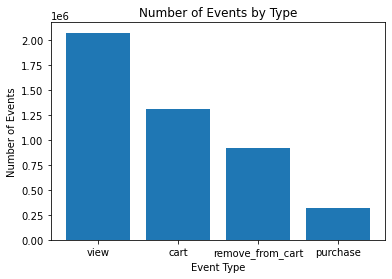

In [7]:
event_counts = data['event_type'].value_counts()
plt.bar(event_counts.index, event_counts.values)
plt.title('Number of Events by Type')
plt.xlabel('Event Type')
plt.ylabel('Number of Events')
plt.show()

#### Q6

In [8]:
session_data= df3[['user_id','user_session','funnel_number','index_in_funnel']]
session_data= session_data.drop_duplicates(subset=["user_session",'funnel_number']).sort_values(['user_id']) #a,b,c,d

session_data['total_events'] = data.groupby('user_session', sort=False)['event_type'].transform('count') #e

session_data['total_duration']=data1.groupby('user_session')['duration_to_next_event'].transform('sum') #f

dt_v= data[data['event_type']=='view'] #g
datav = dt_v.groupby(['user_session']).agg(
{
    'product_id': lambda x: list(x),
    
}).reset_index()
datav.columns = ['user_session','list_of_viewed'] 
session_data= session_data.merge(datav,how='left', on='user_session')

dt_c= data[data['event_type']=='cart'] #h
datac = dt_c.groupby(['user_session']).agg(
{
    'product_id': lambda x: list(x),
    
}).reset_index()
datac.columns = ['user_session','list_of_added_to_cart']
session_data= session_data.merge(datac,how='left', on='user_session')

dt_p= data[data['event_type']=='purchase'] #i
datap = dt_p.groupby(['user_session']).agg(
{
    'product_id': lambda x: list(x),
    
}).reset_index()
datap.columns = ['user_session','list_of_purchased'] 
session_data= session_data.merge(datap,how='left', on='user_session')

session_data.head()

,user_id,user_session,funnel_number,index_in_funnel,total_events,total_duration,list_of_viewed,list_of_added_to_cart,list_of_purchased
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,1.0,0.0,[5240],NaN,NaN
1,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1,1,1.0,0.0,[5814066],NaN,NaN
2,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,2,28.0,3789.0,"[5800358, 5800349, 5800349, 5800358, 5712576, ...",NaN,NaN
3,1458813,ad1a2e9e-cc14-4b98-b70b-5dd539e76bba,1,3,1.0,0.0,[5711087],NaN,NaN
4,1458813,b16644a2-44db-4650-8156-f6f03782d432,1,4,1.0,0.0,[5711145],NaN,NaN
